#**Disease Classification for Tomato**

Dataset Credit: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

##**Pre-Processing**

In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

###**Import dataset**

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Deep Learning/tomato_disease/colour",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE), # 256*256
    batch_size = BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___healthy']

In [11]:
print(len(dataset),"batches")

141 batches


In [12]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[2 2 2 1 1 1 2 2 2 2 2 2 2 0 0 1 2 1 0 2 1 0 0 0 0 2 0 1 1 1 2 2]


###**Some Image Visualization**

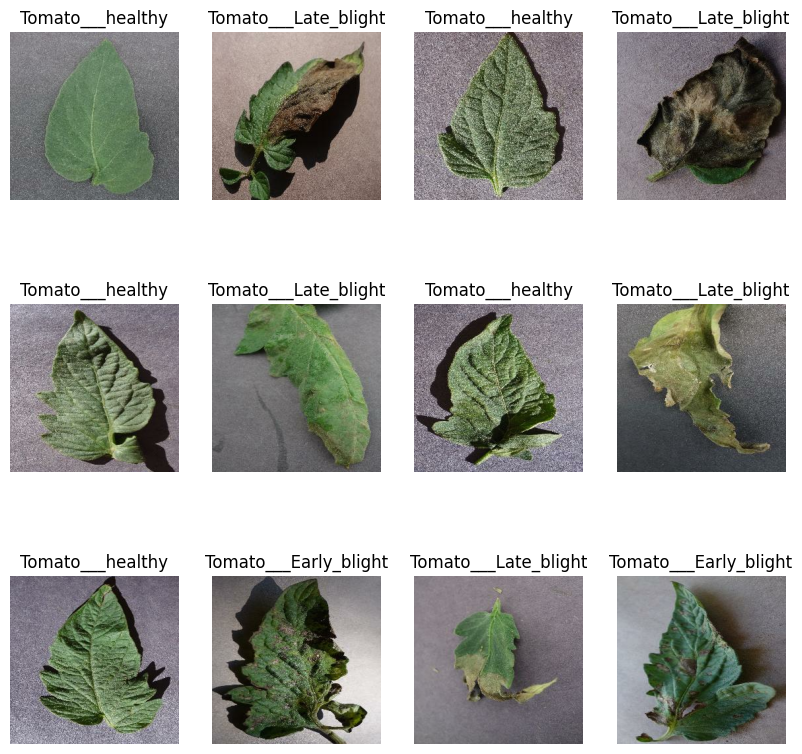

In [13]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

###**Dataset Splitting**

- 80% => Training
- 10% => Validation during Epochs
- 10% => Test

In [14]:
train_size = 0.8
len(dataset)*train_size

112.80000000000001

In [15]:
train_ds = dataset.take(112) # take 112 batches
len(train_ds)

112

In [16]:
rem_ds = dataset.skip(112)
len(rem_ds)

29

In [17]:
val_size = 0.1
len(dataset)*val_size

14.100000000000001

In [18]:
val_ds = rem_ds.take(14)
len(val_ds)

14

In [19]:
test_ds = rem_ds.skip(14)
len(test_ds)

15

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

###**Cache, Shuffle and Prefetch the Dataset**

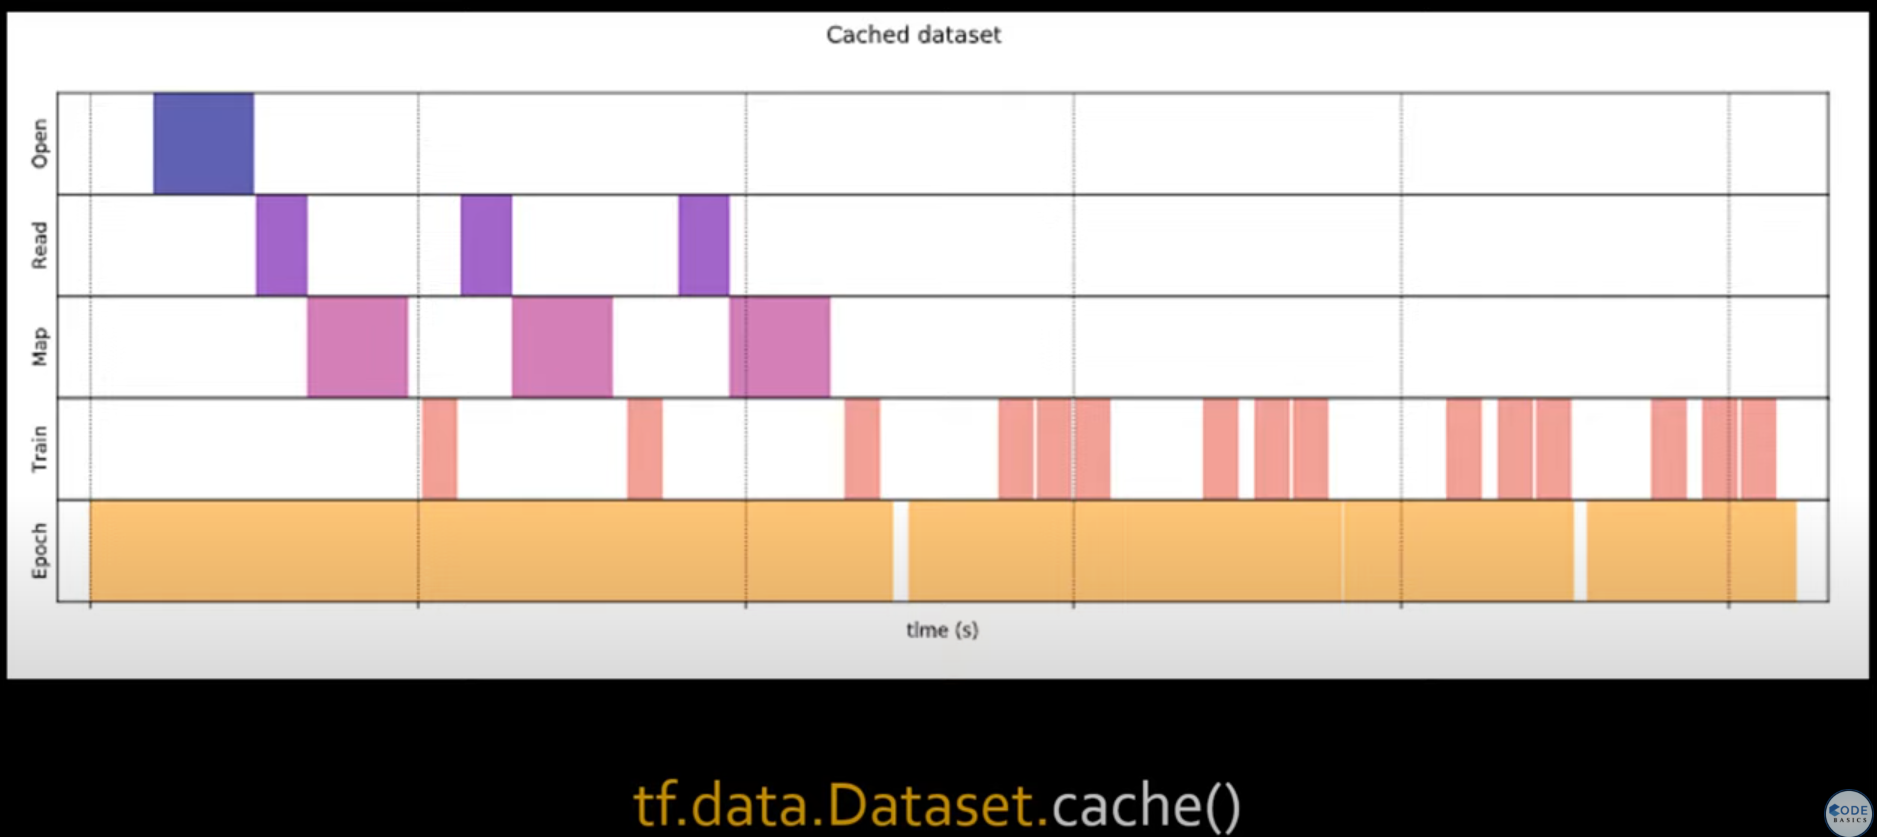

In [21]:
# This code optimizes data loading, shuffling, and prefetching to enhance training speed and efficiency.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

###**Resizing and Normalization Layer**

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

###**Data Augmentation**

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.3),
])

##**Model Building**

###**Convolutional Neural Network (CNN)**

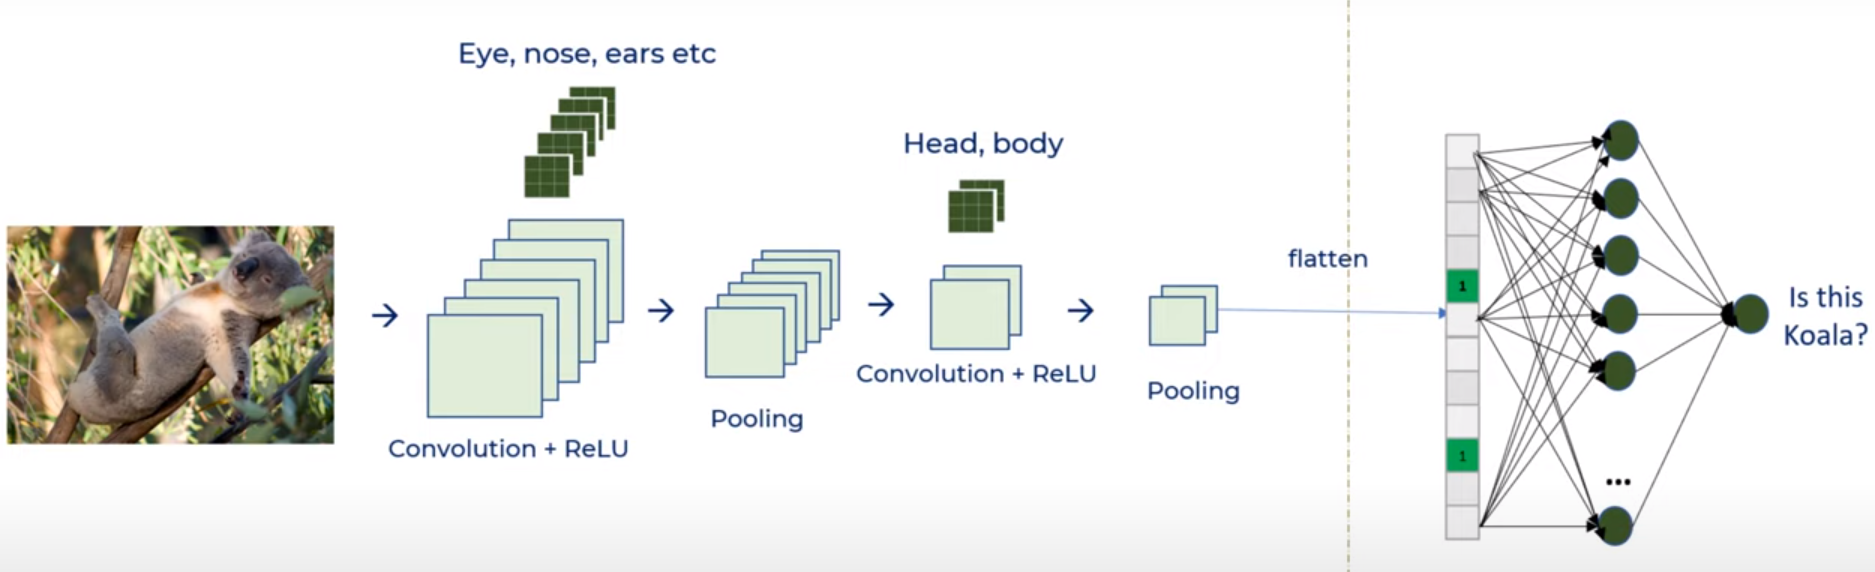

#####**Model Architecture**

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(70, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(200,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(200,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(200, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(200, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(200, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(200, activation='relu'),
    # keras.layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 70)        1960      
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 70)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 200)       126200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 200)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 200)        

####**Model Compile**

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
112/112 [==============================] - 169s 263ms/step - loss: 0.9329 - accuracy: 0.5444 - val_loss: 0.5179 - val_accuracy: 0.7746
Epoch 2/50
112/112 [==============================] - 13s 115ms/step - loss: 0.4919 - accuracy: 0.7905 - val_loss: 0.3481 - val_accuracy: 0.8594
Epoch 3/50
112/112 [==============================] - 13s 115ms/step - loss: 0.4142 - accuracy: 0.8228 - val_loss: 0.3014 - val_accuracy: 0.8750
Epoch 4/50
112/112 [==============================] - 13s 115ms/step - loss: 0.3993 - accuracy: 0.8376 - val_loss: 0.3917 - val_accuracy: 0.8549
Epoch 5/50
112/112 [==============================] - 13s 115ms/step - loss: 0.3413 - accuracy: 0.8622 - val_loss: 0.2512 - val_accuracy: 0.8906
Epoch 6/50
112/112 [==============================] - 13s 115ms/step - loss: 0.3093 - accuracy: 0.8811 - val_loss: 0.4027 - val_accuracy: 0.8549
Epoch 7/50
112/112 [==============================] - 13s 115ms/step - loss: 0.2594 - accuracy: 0.8951 - val_loss: 0.2786 - val_a

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 49s 139ms/step - loss: 0.2036 - accuracy: 0.9637


In [30]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

test_loss_score = scores[0]
test_accuracy_score = scores[1]

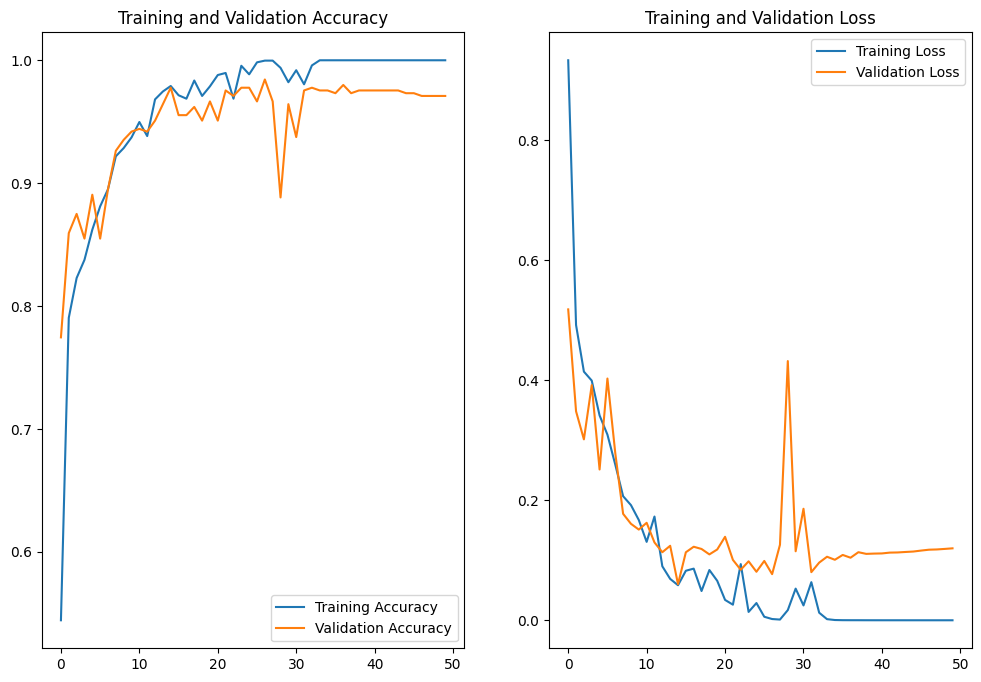

In [31]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####**Sample Image Prediction**

first image to predict
actual label: Tomato___Late_blight
1/1 [==============================] - 0s 338ms/step
predicted label: Tomato___Early_blight


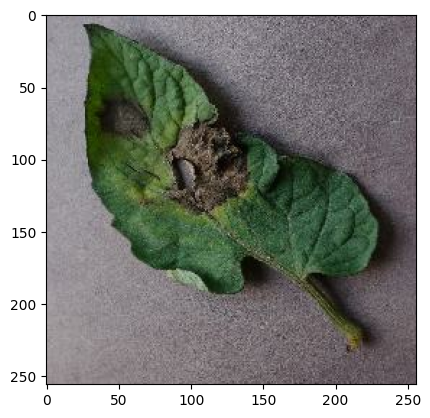

In [32]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

###**Saving our Model**

In [35]:
# model.save(f"/content/drive/MyDrive/Colab Notebooks/Deep Learning/tomato_disease/models/{1}")

In [39]:
# model.save(f"/content/drive/MyDrive/Colab Notebooks/Deep Learning/tomato_disease/models/tomato.h5")

In [37]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")